In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import os
if not os.path.isdir('figures'):
    os.makedirs('figures')

In [2]:
epochs = 1500
batch_size = 8
num_neurons = 10
seed = 10

beta = 1e-3
alpha = 1e-3

l2=keras.regularizers.l2(beta)
sgd=keras.optimizers.SGD(learning_rate=alpha)

histories={}

np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#read and divide data into test and train sets 
admit_data = np.genfromtxt('admission_predict.csv', delimiter= ',')
X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
Y_data = Y_data.reshape(Y_data.shape[0], 1)

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data,test_size = 0.3, random_state = seed, shuffle=True)

#Preprocess by standardizing the Xtrain and Xtest based on Xtrain stats
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
train_data_6_feature = []
test_data_6_feature = []

#Make train and test set for 6 features RFE.
for feature_idx in range(7):
    temp = np.delete(X_train,obj=feature_idx,axis=1)
    train_data_6_feature.append(temp)
    temp = np.delete(X_test,obj=feature_idx,axis=1)
    test_data_6_feature.append(temp)
    
#keep model with lowest m.s.e (model that removed feature 6 Research has lowest average test mse)
X6_train, X6_test = train_data_6_feature[6],test_data_6_feature[6]

In [5]:
train_data_5_feature = []
test_data_5_feature = []

#Make train and test set for 5 features RFE.
for feature_idx in range(6):
    temp = np.delete(X6_train,obj=feature_idx,axis=1)
    train_data_5_feature.append(temp)
    temp = np.delete(X6_test,obj=feature_idx,axis=1)
    test_data_5_feature.append(temp)
    
#Keep model with lowest MSE (from removing the feature 3 or SOP)
X5_train, X5_test = train_data_5_feature[3],test_data_5_feature[3]

In [6]:
print(X6_train)

[[ 1.42832554  1.60033916  0.81007205  1.61476636  0.63111055  1.75693791]
 [ 2.03141     2.09401705  1.68922001  1.12224503  1.17990233  1.65722655]
 [-1.07016722 -0.86805029 -0.94822387 -0.35531896  0.63111055  0.21141182]
 ...
 [-0.20861799 -0.3743724  -0.06907591  0.13720237 -1.0152648  -0.50318626]
 [-1.41478691 -1.19716888 -0.06907591 -1.34036162 -0.46647302  0.0950819 ]
 [-0.29477291 -0.86805029 -0.06907591 -0.84784029 -1.0152648   0.12831902]]


In [7]:
print(X5_train)

[[ 1.42832554  1.60033916  0.81007205  0.63111055  1.75693791]
 [ 2.03141     2.09401705  1.68922001  1.17990233  1.65722655]
 [-1.07016722 -0.86805029 -0.94822387  0.63111055  0.21141182]
 ...
 [-0.20861799 -0.3743724  -0.06907591 -1.0152648  -0.50318626]
 [-1.41478691 -1.19716888 -0.06907591 -0.46647302  0.0950819 ]
 [-0.29477291 -0.86805029 -0.06907591 -1.0152648   0.12831902]]


In [8]:
print(X6_test)

[[-0.72554753 -0.2098131  -0.06907591  0.13720237 -1.0152648  -0.6527533 ]
 [ 0.39446647  0.28386479  0.81007205  0.6297237   0.63111055  0.12831902]
 [-1.15632214 -1.19716888 -0.94822387 -0.35531896  0.08231877 -0.9020317 ]
 [-1.84556153 -1.36172818 -0.94822387 -0.84784029 -0.46647302 -1.58339266]
 [-0.03630815 -0.86805029 -0.06907591 -1.34036162 -0.46647302 -1.99885666]
 [-0.46708276 -1.36172818 -1.82737184 -0.84784029 -0.46647302 -0.28714498]
 [ 2.03141     2.09401705  0.81007205  1.61476636  1.72869412  1.49104095]
 [ 1.2560157   1.60033916  0.81007205  1.12224503  1.72869412  1.35809247]
 [ 1.2560157   1.27122056  1.68922001  0.6297237   0.08231877  1.39132959]
 [-0.9840123   0.11930549  1.68922001 -0.35531896 -0.46647302 -0.20405218]
 [ 0.91139601 -0.5389317   1.68922001 -0.35531896  0.08231877  0.39421598]
 [ 0.48062139  0.44842408  0.81007205  0.6297237   1.72869412  0.87615422]
 [ 0.39446647  0.28386479 -0.06907591 -0.35531896 -0.46647302 -0.10434082]
 [-0.12246307 -1.19716888

In [9]:
print(X5_test)

[[-0.72554753 -0.2098131  -0.06907591 -1.0152648  -0.6527533 ]
 [ 0.39446647  0.28386479  0.81007205  0.63111055  0.12831902]
 [-1.15632214 -1.19716888 -0.94822387  0.08231877 -0.9020317 ]
 [-1.84556153 -1.36172818 -0.94822387 -0.46647302 -1.58339266]
 [-0.03630815 -0.86805029 -0.06907591 -0.46647302 -1.99885666]
 [-0.46708276 -1.36172818 -1.82737184 -0.46647302 -0.28714498]
 [ 2.03141     2.09401705  0.81007205  1.72869412  1.49104095]
 [ 1.2560157   1.60033916  0.81007205  1.72869412  1.35809247]
 [ 1.2560157   1.27122056  1.68922001  0.08231877  1.39132959]
 [-0.9840123   0.11930549  1.68922001 -0.46647302 -0.20405218]
 [ 0.91139601 -0.5389317   1.68922001  0.08231877  0.39421598]
 [ 0.48062139  0.44842408  0.81007205  1.72869412  0.87615422]
 [ 0.39446647  0.28386479 -0.06907591 -0.46647302 -0.10434082]
 [-0.12246307 -1.19716888 -1.82737184 -1.0152648  -1.08483586]
 [ 1.68679031  1.92945775  1.68922001  0.08231877  1.98959775]
 [ 1.08370585  0.94210197  1.68922001  1.17990233  1.40

In [10]:
# build_fn for sklearn wrapped
def get_baseline_model(input_size):
    model = keras.Sequential()
    model.add(keras.layers.Dense(num_neurons, input_dim = input_size, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=sgd,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])
    
    return model

In [11]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_mse',patience=10,mode="min",min_delta=1e-5)

In [12]:
mse_all = []
for i in range (5):
    print("Experiments %s"%i)
    #Full
    input_size = X_train.shape[1]
    model = get_baseline_model(input_size)
    results = model.fit(X_train,Y_train, validation_data = (X_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[early_stopper])
    best_full_mse = min(results.history['val_mse'])
    print("min m.s.e for full features: %.5f"%best_full_mse)
    
    #6 features
    input_size = X6_train.shape[1]
    model_6 = get_baseline_model(input_size)
    results_6 = model_6.fit(X6_train,Y_train, validation_data = (X6_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[early_stopper])
    best_6_mse = min(results_6.history['val_mse'])
    print("min m.s.e for 6 features: %.5f"%best_6_mse)
        
    #5 features
    input_size = X5_train.shape[1]
    model_5 = get_baseline_model(input_size)
    results_5 = model_5.fit(X5_train,Y_train, validation_data = (X5_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[early_stopper])
    best_5_mse = min(results_5.history['val_mse'])
    print("min m.s.e for 5 features: %.5f"%best_5_mse)
    mse_all.append([best_full_mse,best_6_mse,best_5_mse])


Experiments 0
min m.s.e for full features: 0.00757
min m.s.e for 6 features: 0.00764
min m.s.e for 5 features: 0.00605
Experiments 1
min m.s.e for full features: 0.00651
min m.s.e for 6 features: 0.00675
min m.s.e for 5 features: 0.00624
Experiments 2
min m.s.e for full features: 0.00620
min m.s.e for 6 features: 0.00655
min m.s.e for 5 features: 0.00594
Experiments 3
min m.s.e for full features: 0.00684
min m.s.e for 6 features: 0.00616
min m.s.e for 5 features: 0.00599
Experiments 4
min m.s.e for full features: 0.00866
min m.s.e for 6 features: 0.00615
min m.s.e for 5 features: 0.00622


In [15]:
print(mse_all)
mse_ave = np.array(mse_all).mean(axis=0)
print(mse_ave)

[[0.007567731663584709, 0.007637902162969112, 0.00605161814019084], [0.006514870561659336, 0.006751124281436205, 0.0062438552267849445], [0.006204974837601185, 0.006549794692546129, 0.00593941193073988], [0.006838631816208363, 0.00615816842764616, 0.005990255158394575], [0.008659182116389275, 0.00615155091509223, 0.00622157845646143]]
[0.00715708 0.00664971 0.00608934]


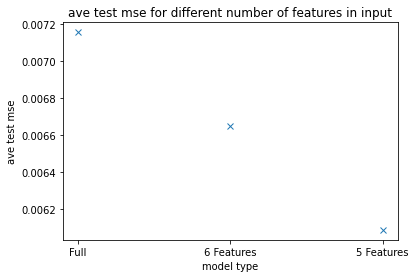

In [17]:
plt.plot(['Full','6 Features','5 Features'],mse_ave,linestyle='None',marker='x')
plt.ylabel('ave test mse')
plt.xlabel('model type')
plt.title('ave test mse for different number of features in input')
plt.savefig('./figures/2B_ave_5_experiments_test_mse.png')